In [2]:
!conda list

# packages in environment at /Users/rohan/opt/anaconda3/envs/mldd:
#
# Name                    Version                   Build  Channel
absl-py                   0.14.1                   pypi_0    pypi
accelerate                1.0.1                    pypi_0    pypi
adjusttext                0.8                      pypi_0    pypi
aiohappyeyeballs          2.4.3                    pypi_0    pypi
aiohttp                   3.10.10                  pypi_0    pypi
aiosignal                 1.3.1                    pypi_0    pypi
annotated-types           0.7.0                    pypi_0    pypi
appdirs                   1.4.4                    pypi_0    pypi
appnope                   0.1.2            py38h50d1736_1    conda-forge
argon2-cffi               20.1.0           py38h96a0964_2    conda-forge
astunparse                1.6.3                    pypi_0    pypi
async-timeout             4.0.3                    pypi_0    pypi
async_generator           1.10                       py_0 

In [9]:
!pip install -U pydantic

In [2]:
!pip install peft

     |████████████████████████████████| 320 kB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 247 kB 6.0 MB/s eta 0:00:01
     |████████████████████████████████| 330 kB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 150.6 MB 154 kB/s  eta 0:00:01    |████████████████▊               | 78.6 MB 35.6 MB/s eta 0:00:03     |███████████████████████         | 108.0 MB 10.5 MB/s eta 0:00:05
     |████████████████████████████████| 6.2 MB 28.2 MB/s eta 0:00:01
     |████████████████████████████████| 536 kB 33.6 MB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1.post3
    Uninstalling torch-1.9.1.post3:
      Successfully uninstalled torch-1.9.1.post3


In [1]:
import os
import sys

# This is to force the path to be on the same level as the balm folder
sys.path.append("../..")

from transformers import AutoTokenizer
import torch
from datasets import load_dataset
from balm import common_utils
from balm.models.utils import load_trained_model, load_pretrained_pkd_bounds
from balm.configs import Configs
from balm.models import BALM

DEVICE = "cpu"

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_hyperparameters" in ModelConfigs has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_configs" in Configs has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


# Load Pretrained BindingDB BALM

In [5]:
config_filepath = "../../default_configs/balm_peft.yaml"
configs = Configs(**common_utils.load_yaml(config_filepath))

# Load the model
model = BALM(configs.model_configs)
model = load_trained_model(model, configs.model_configs, is_training=False)
model.to(DEVICE)
model.eval()
# Pretrained pKd lower and upper bounds
pkd_lower_bound, pkd_upper_bound = load_pretrained_pkd_bounds(configs.model_configs.checkpoint_path)

# Load the tokenizers
protein_tokenizer = AutoTokenizer.from_pretrained(
    configs.model_configs.protein_model_name_or_path
)
drug_tokenizer = AutoTokenizer.from_pretrained(
    configs.model_configs.drug_model_name_or_path
)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 128,160 || all params: 148,923,641 || trainable%: 0.0861
trainable params: 221,184 || all params: 3,648,624 || trainable%: 6.0621
Loading checkpoint from BALM/bdb-cleaned-r-esm-lokr-chemberta-loha-cosinemse


pytorch_model.bin:   0%|          | 0.00/612M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

Merging protein model with its adapter
Merging drug model with its adapter


## Check if the loading is correct, the model should be able to perform well in BindingDB dataset

In [6]:
import time

# Take just 10 data
bindingdb_samples = load_dataset("BALM/BALM-benchmark", "BindingDB_filtered", split="train[:100]")

# Let's time it! Note: This is not a batched prediction!
start = time.time()
predictions = []
labels = []
for sample in bindingdb_samples:
    # Prepare input
    protein_inputs = protein_tokenizer(sample["Target"], return_tensors="pt").to(DEVICE)
    drug_inputs = drug_tokenizer(sample["Drug"], return_tensors="pt").to(DEVICE)
    inputs = {
        "protein_input_ids": protein_inputs["input_ids"],
        "protein_attention_mask": protein_inputs["attention_mask"],
        "drug_input_ids": drug_inputs["input_ids"],
        "drug_attention_mask": drug_inputs["attention_mask"],
    }
    prediction = model(inputs)["cosine_similarity"]
    prediction = model.cosine_similarity_to_pkd(prediction, pkd_upper_bound=pkd_upper_bound, pkd_lower_bound=pkd_lower_bound)
    label = torch.tensor([sample["Y"]])

    print(f"Predicted pKd: {prediction.item()} | True pKd: {label.item()}")
    predictions.append(prediction.item())
    labels.append(label.item())
print(f"Time taken for 100 protein-ligand pairs: {time.time() - start}")

README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

data-00000-of-00001.arrow:   0%|          | 0.00/19.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24700 [00:00<?, ? examples/s]

Predicted pKd: 8.857807159423828 | True pKd: 9.251811981201172
Predicted pKd: 8.924827575683594 | True pKd: 9.229147911071777
Predicted pKd: 8.64533519744873 | True pKd: 9.031517028808594
Predicted pKd: 8.825891494750977 | True pKd: 9.522878646850586
Predicted pKd: 8.931111335754395 | True pKd: 9.585026741027832
Predicted pKd: 8.992443084716797 | True pKd: 9.376750946044922
Predicted pKd: 8.703511238098145 | True pKd: 9.638272285461426
Predicted pKd: 8.894314765930176 | True pKd: 9.698969841003418
Predicted pKd: 8.81692123413086 | True pKd: 9.698969841003418
Predicted pKd: 8.81692123413086 | True pKd: 8.74472713470459
Predicted pKd: 8.902658462524414 | True pKd: 9.638272285461426
Predicted pKd: 5.815732955932617 | True pKd: 5.394684314727783
Predicted pKd: 7.680473327636719 | True pKd: 6.6987528800964355
Predicted pKd: 7.355868339538574 | True pKd: 7.11861515045166
Predicted pKd: 7.308740615844727 | True pKd: 6.638083457946777
Predicted pKd: 7.825357437133789 | True pKd: 6.920456886291

Text(0, 0.5, 'Predicted $pK_d$')

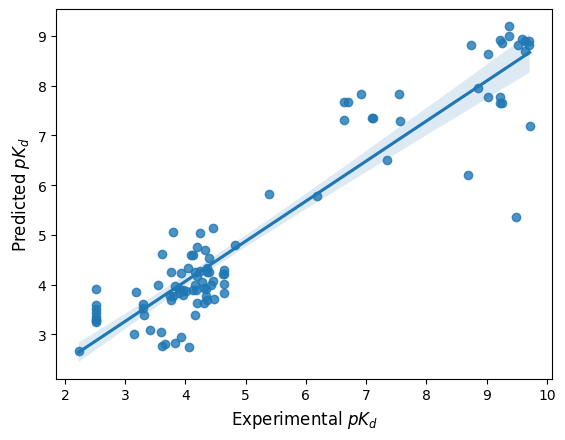

In [11]:
import seaborn as sns

ax = sns.regplot(x=labels, y=predictions)
ax.set_xlabel(r'Experimental $pK_d$',fontsize=12)
ax.set_ylabel(r'Predicted $pK_d$',fontsize=12)


# Zero-shot on new Target (MCL1)

In [12]:
# Note: train split is just because it's the default split for the dataset
mcl_data = load_dataset("BALM/BALM-benchmark", "MCL1", split="train")

data-00000-of-00001.arrow:   0%|          | 0.00/6.39k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25 [00:00<?, ? examples/s]

In [13]:
start = time.time()
for sample in mcl_data:
    # Prepare input
    protein_inputs = protein_tokenizer(sample["Target"], return_tensors="pt").to(DEVICE)
    drug_inputs = drug_tokenizer(sample["Drug"], return_tensors="pt").to(DEVICE)
    inputs = {
        "protein_input_ids": protein_inputs["input_ids"],
        "protein_attention_mask": protein_inputs["attention_mask"],
        "drug_input_ids": drug_inputs["input_ids"],
        "drug_attention_mask": drug_inputs["attention_mask"],
    }
    prediction = model(inputs)["cosine_similarity"]
    prediction = model.cosine_similarity_to_pkd(prediction, pkd_upper_bound=pkd_upper_bound, pkd_lower_bound=pkd_lower_bound)
    label = torch.tensor([sample["Y"]])

    print(f"Predicted pKd: {prediction.item()} | True pKd: {label.item()}")
    predictions.append(prediction.item())
    labels.append(label.item())
print(f"Time taken for zero-shot prediction: {time.time() - start}")

Predicted pKd: 4.687337875366211 | True pKd: 4.455932140350342
Predicted pKd: 4.799520492553711 | True pKd: 4.823908805847168
Predicted pKd: 4.840061664581299 | True pKd: 5.721246242523193
Predicted pKd: 4.6916422843933105 | True pKd: 5.7695512771606445
Predicted pKd: 4.794649600982666 | True pKd: 4.79587984085083
Predicted pKd: 4.777118682861328 | True pKd: 5.0087738037109375
Predicted pKd: 4.694001197814941 | True pKd: 5.004364967346191
Predicted pKd: 4.922251224517822 | True pKd: 6.4202165603637695
Predicted pKd: 4.802126884460449 | True pKd: 5.958607196807861
Predicted pKd: 5.07747745513916 | True pKd: 6.522878646850586
Predicted pKd: 4.931079864501953 | True pKd: 5.12493896484375
Predicted pKd: 4.930351734161377 | True pKd: 5.537601947784424
Predicted pKd: 5.17240047454834 | True pKd: 4.207608222961426
Predicted pKd: 5.050621509552002 | True pKd: 4.853871822357178
Predicted pKd: 5.165882110595703 | True pKd: 6.091515064239502
Predicted pKd: 5.262083053588867 | True pKd: 6.79587984

RMSE: 0.932243824005127
Pearson: 0.9117612838745117
Spearman: 0.8908201341159971
CI: 0.8582196235656738


Text(0, 0.5, 'Predicted $pK_d$')

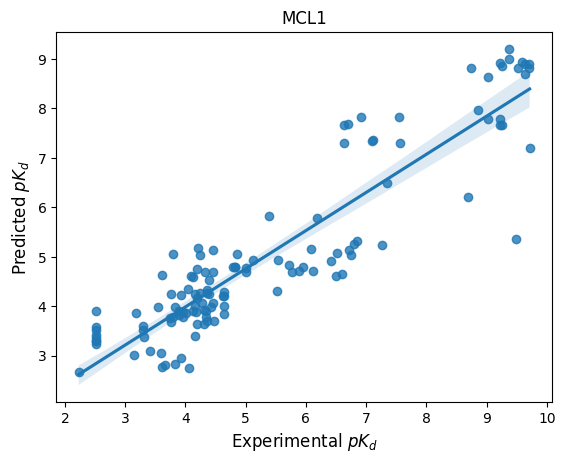

In [14]:
from balm.metrics import get_ci, get_pearson, get_rmse, get_spearman

rmse = get_rmse(torch.tensor(labels), torch.tensor(predictions))
pearson = get_pearson(torch.tensor(labels), torch.tensor(predictions))
spearman = get_spearman(torch.tensor(labels), torch.tensor(predictions))
ci = get_ci(torch.tensor(labels), torch.tensor(predictions))

print(f"RMSE: {rmse}")
print(f"Pearson: {pearson}")
print(f"Spearman: {spearman}")
print(f"CI: {ci}")

ax = sns.regplot(x=labels, y=predictions)
ax.set_title(f"MCL1")
ax.set_xlabel(r'Experimental $pK_d$',fontsize=12)
ax.set_ylabel(r'Predicted $pK_d$',fontsize=12)

# Few shot training

Note: This is a simplified training process, for a more tested approach, please refer to our `balm/trainer.py`

In [15]:
# Split data
train_test_split = mcl_data.train_test_split(train_size=0.2, seed=1234)

train_mcl_data = train_test_split["train"]
test_mcl_data = train_test_split["test"]

In [16]:
# Define a function that applies the cosine similarity conversion to a single example
# This is VERY IMPORTANT since BALM uses cosine similarity
def add_cosine_similarity(example, pkd_upper_bound, pkd_lower_bound):
    example['cosine_similarity'] = (
        (example['Y'] - pkd_lower_bound)
        / (pkd_upper_bound - pkd_lower_bound)
        * 2
        - 1
    )
    return example

# Use map to apply the function across the entire dataset
train_mcl_data = train_mcl_data.map(lambda x: add_cosine_similarity(x, pkd_upper_bound, pkd_lower_bound))
test_mcl_data = test_mcl_data.map(lambda x: add_cosine_similarity(x, pkd_upper_bound, pkd_lower_bound))

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [17]:
print(f"Number of train data: {len(train_mcl_data)}")
print(f"Number of test data: {len(test_mcl_data)}")

Number of train data: 5
Number of test data: 20


In [18]:
model = BALM(configs.model_configs)
model = load_trained_model(model, configs.model_configs, is_training=True)
model = model.to(DEVICE)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 128,160 || all params: 148,923,641 || trainable%: 0.0861
trainable params: 221,184 || all params: 3,648,624 || trainable%: 6.0621
Loading checkpoint from BALM/bdb-cleaned-r-esm-lokr-chemberta-loha-cosinemse
Merging protein model with its adapter
Merging drug model with its adapter
protein_projection.weight
protein_projection.bias
drug_projection.weight
drug_projection.bias
trainable params: 262,656 || all params: 152,485,577 || trainable%: 0.17224973349446682


In [19]:
from torch.optim import AdamW

NUM_EPOCHS = 10
optimizer = AdamW(
    params=[
        param
        for name, param in model.named_parameters()
    ],
    lr=configs.model_configs.model_hyperparameters.learning_rate,
)

start = time.time()
for epoch in range(NUM_EPOCHS):
    model.train()  # Set the model to training mode
    total_loss = 0.0  # To track the loss for each epoch

    for sample in train_mcl_data:
        # Prepare input
        protein_inputs = protein_tokenizer(sample["Target"], return_tensors="pt").to(DEVICE)
        drug_inputs = drug_tokenizer(sample["Drug"], return_tensors="pt").to(DEVICE)
        # Move labels to the appropriate device and ensure it's a tensor
        labels = torch.tensor([sample["cosine_similarity"]], dtype=torch.float32).to(DEVICE)

        inputs = {
            "protein_input_ids": protein_inputs["input_ids"],
            "protein_attention_mask": protein_inputs["attention_mask"],
            "drug_input_ids": drug_inputs["input_ids"],
            "drug_attention_mask": drug_inputs["attention_mask"],
            "labels": labels,  # Add labels for training
        }

        # Forward pass
        outputs = model(inputs)

        # Assume the model's output dictionary contains 'loss'
        loss = outputs["loss"]

        # Backpropagation
        optimizer.zero_grad()  # Zero out the gradients to avoid accumulation
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        total_loss += loss.item()
    
    # Log the loss for this epoch
    avg_loss = total_loss / len(train_mcl_data)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}")

print("Training complete! Time taken: ", time.time() - start)

Epoch [1/10], Loss: 0.0873
Epoch [2/10], Loss: 0.0292
Epoch [3/10], Loss: 0.0394
Epoch [4/10], Loss: 0.0314
Epoch [5/10], Loss: 0.0247
Epoch [6/10], Loss: 0.0246
Epoch [7/10], Loss: 0.0266
Epoch [8/10], Loss: 0.0162
Epoch [9/10], Loss: 0.0204
Epoch [10/10], Loss: 0.0164
Training complete! Time taken:  51.51147794723511


## Test the model!

In [20]:
model = model.eval()

predictions = []
labels = []
for sample in test_mcl_data:
    # Prepare input
    protein_inputs = protein_tokenizer(sample["Target"], return_tensors="pt").to(DEVICE)
    drug_inputs = drug_tokenizer(sample["Drug"], return_tensors="pt").to(DEVICE)
    inputs = {
        "protein_input_ids": protein_inputs["input_ids"],
        "protein_attention_mask": protein_inputs["attention_mask"],
        "drug_input_ids": drug_inputs["input_ids"],
        "drug_attention_mask": drug_inputs["attention_mask"],
    }
    prediction = model(inputs)["cosine_similarity"]
    prediction = model.cosine_similarity_to_pkd(prediction, pkd_upper_bound=pkd_upper_bound, pkd_lower_bound=pkd_lower_bound)
    label = torch.tensor([sample["Y"]])

    print(f"Predicted pKd: {prediction.item()} | True pKd: {label.item()}")
    predictions.append(prediction.item())
    labels.append(label.item())
print(f"Time taken for {len(test_mcl_data)} protein-ligand pairs: {time.time() - start}")

Predicted pKd: 5.965458869934082 | True pKd: 5.886056423187256
Predicted pKd: 5.996294975280762 | True pKd: 6.522878646850586
Predicted pKd: 5.8233137130737305 | True pKd: 4.853871822357178
Predicted pKd: 5.740767478942871 | True pKd: 5.12493896484375
Predicted pKd: 5.9644904136657715 | True pKd: 6.12493896484375
Predicted pKd: 5.654372215270996 | True pKd: 5.0087738037109375
Predicted pKd: 5.661068916320801 | True pKd: 5.7695512771606445
Predicted pKd: 5.77578592300415 | True pKd: 5.522878646850586
Predicted pKd: 5.755428791046143 | True pKd: 5.958607196807861
Predicted pKd: 5.7984490394592285 | True pKd: 5.721246242523193
Predicted pKd: 6.194129467010498 | True pKd: 7.259637355804443
Predicted pKd: 5.556243419647217 | True pKd: 4.455932140350342
Predicted pKd: 6.105380535125732 | True pKd: 6.721246242523193
Predicted pKd: 5.90826416015625 | True pKd: 5.537601947784424
Predicted pKd: 6.161271572113037 | True pKd: 6.79587984085083
Predicted pKd: 5.935245513916016 | True pKd: 4.20760822

RMSE: 0.7222705483436584
Pearson: 0.7394261956214905
Spearman: 0.7533834586466165
CI: 0.8052631616592407


Text(0, 0.5, 'Predicted $pK_d$')

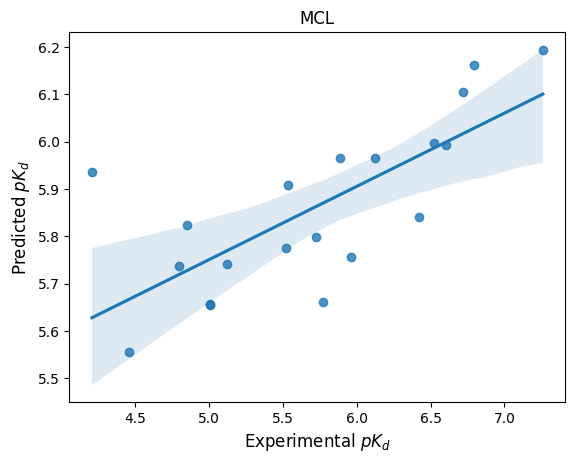

In [21]:
from balm.metrics import get_ci, get_pearson, get_rmse, get_spearman

rmse = get_rmse(torch.tensor(labels), torch.tensor(predictions))
pearson = get_pearson(torch.tensor(labels), torch.tensor(predictions))
spearman = get_spearman(torch.tensor(labels), torch.tensor(predictions))
ci = get_ci(torch.tensor(labels), torch.tensor(predictions))

print(f"RMSE: {rmse}")
print(f"Pearson: {pearson}")
print(f"Spearman: {spearman}")
print(f"CI: {ci}")

ax = sns.regplot(x=labels, y=predictions)
ax.set_title(f"MCL")
ax.set_xlabel(r'Experimental $pK_d$',fontsize=12)
ax.set_ylabel(r'Predicted $pK_d$',fontsize=12)